# Estudio de la evolución de la pandemia por el modelo de red neuronal recurrente para la isla de Tenerife

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras import regularizers

In [2]:
def get_X_y(datos, dias):
    
    X, y = [], []
    
    for i in range(len(datos) - dias):
        X.append(datos[i:(i + dias), :])
        y.append(datos[i + dias, 0])
        
    return np.array(X), np.array(y)

def visualizar_pred_test(y_test, y_pred, fechas, tit):
    plt.figure(figsize=(16, 6))
    plt.plot(fechas, y_test, label='Test', color='green')
    plt.plot(fechas, y_pred, label='Predicciones', color='orange')
    plt.xticks(rotation=60)
    plt.xlabel('Fechas')
    plt.ylabel('Número de casos de COVID')
    plt.title(tit)
    plt.legend()
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, indices, tit):
    train_s = train.iloc[len(train) - dias_historico:]
    color_isla = 'blue'
    
    plt.figure(figsize=(10, 6))
    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color_isla)
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color_isla)
    plt.plot(indices, y_test, label='Test', color='green')
    plt.plot(indices, y_pred, label='Predicciones', color='orange')
    
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(indices), step=5),   train_s.index.union(indices)[::5], rotation=60)

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test):
    modelo = Sequential()
    neurons= X_train.shape[1]
    modelo.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    modelo.add(LSTM(X_train.shape[1] * X_train.shape[2], 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.1))
    modelo.add(LSTM(50, 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.1))
    modelo.add(LSTM(25, 
                   activation='relu',
                   return_sequences=False))
    modelo.add(Dropout(0.1))
    #modelo.add(Dense(5, activation='relu'))
    modelo.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.01)))
    modelo.compile(optimizer='rmsprop', loss='mean_squared_error')
    modelo.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)
    
    return modelo
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_resultados_texto(y_test, y_pred, fechas):
    for i in range(len(y_test)):
        print(str(fechas[i]) + ': número de casos reales ' + str(int(y_test[i][0])) + ', número de casos predichos ' + str(y_pred[i][0]))

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos_islas = pd.read_csv('../data/Final/datos_final.csv', header=0)

# Obtenemos los datos de la isla a la que se le va a realizar el estudio
datos_Tenerife = datos_islas[datos_islas['isla'] == 'TENERIFE']

# Ordenamos por fecha por si los datos devueltos no estuvieran en orden
datos_LaPalma = datos_Tenerife.sort_values(by='fecha')

# Añadimos como índice de los datos la fecha
datos_Tenerife = datos_Tenerife.set_index('fecha') # Asignamos la fecha como índice

In [4]:
# Variables globales a utilizar en todo el proceso

objetivo = 'numero_casos' # Variable objetivo
dias_prediccion = 10      # días a predecir y a agrupar para cada predicción
isla = 'Tenerife'         # Isla a la que se está realziando el estudio
fechas = datos_Tenerife.tail(dias_prediccion).index # Fechas de los días a predecir


variables_covid = [objetivo, 'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']    # Atributos para el análisis de las variables pandémicas
variables_atm = [objetivo, 'tmin', 'tmed', 'presMax']                            # Atributos para el análisis de las variables atmosféricas
variables = [objetivo,'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables


In [5]:

# Cargamos los datos de cada estudio con sus atributos correspondientes
datos_Tenerife_uni = datos_Tenerife[objetivo]
datos_Tenerife_uni_arr = np.array(datos_Tenerife_uni).reshape(-1, 1)

datos_Tenerife_mult_covid = datos_Tenerife[variables_covid]
datos_Tenerife_mult_atm = datos_Tenerife[variables_atm]
datos_Tenerife_mult_total = datos_Tenerife[variables]

# Red Neuronal Recurrente univariable

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_uni_scaled = scaler.fit_transform(datos_Tenerife_uni_arr)

In [7]:
n_train = len(datos_Tenerife_uni_scaled) - dias_prediccion


train = datos_Tenerife_uni_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_uni_scaled[n_train - dias_prediccion:len(datos_Tenerife_uni_scaled), :]

In [8]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 3s 74ms/step - loss: 0.0441 - val_loss: 0.0255
Epoch 2/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0389 - val_loss: 0.0238
Epoch 3/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0362 - val_loss: 0.0226
Epoch 4/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0334 - val_loss: 0.0221
Epoch 5/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0314 - val_loss: 0.0208
Epoch 6/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0285 - val_loss: 0.0200
Epoch 7/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0263 - val_loss: 0.0196
Epoch 8/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0251 - val_loss: 0.0194
Epoch 9/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0235 - val_loss: 0.0196
Epoch 10/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0235 - val_loss: 0.0229
Epoch 11/50
7/7 [============

In [10]:
test_pred = modelo.predict(X_test)
y_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 321ms/step


In [11]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 269, número de casos predichos 820.57416
2022-03-20: número de casos reales 193, número de casos predichos 786.04846
2022-03-21: número de casos reales 636, número de casos predichos 744.7032
2022-03-22: número de casos reales 760, número de casos predichos 694.28894
2022-03-23: número de casos reales 716, número de casos predichos 705.46936
2022-03-24: número de casos reales 607, número de casos predichos 732.43274
2022-03-25: número de casos reales 636, número de casos predichos 667.4822
2022-03-26: número de casos reales 266, número de casos predichos 610.7192
2022-03-27: número de casos reales 163, número de casos predichos 578.8442
2022-03-28: número de casos reales 319, número de casos predichos 568.81836


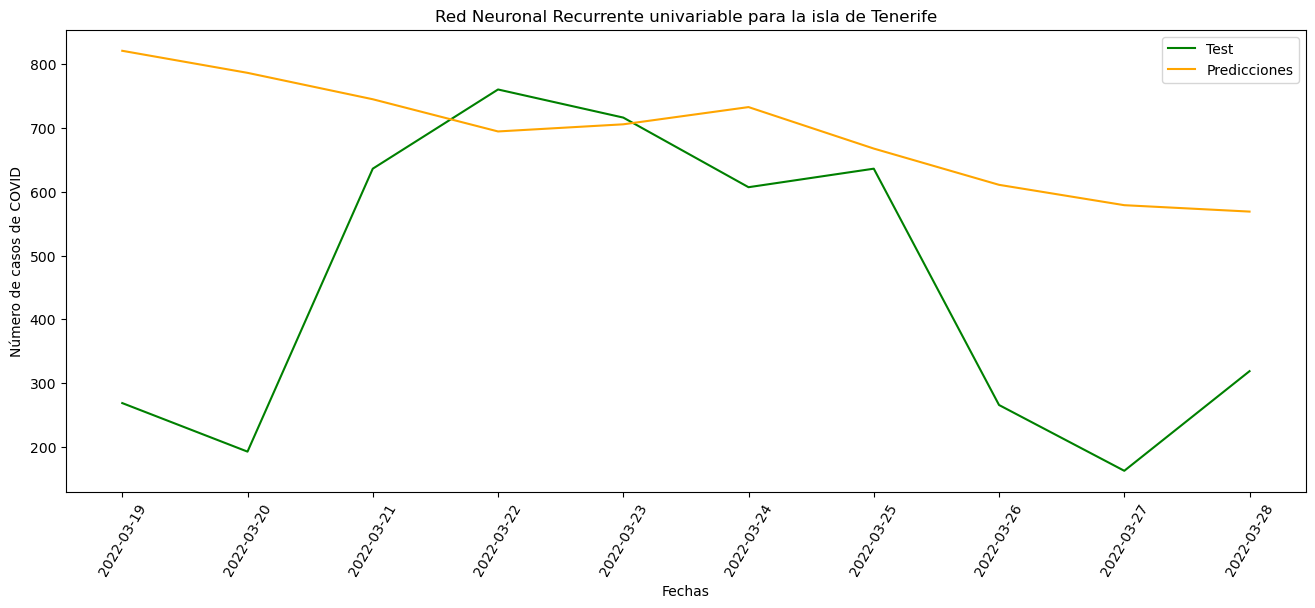

In [12]:
tit = 'Red Neuronal Recurrente univariable para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

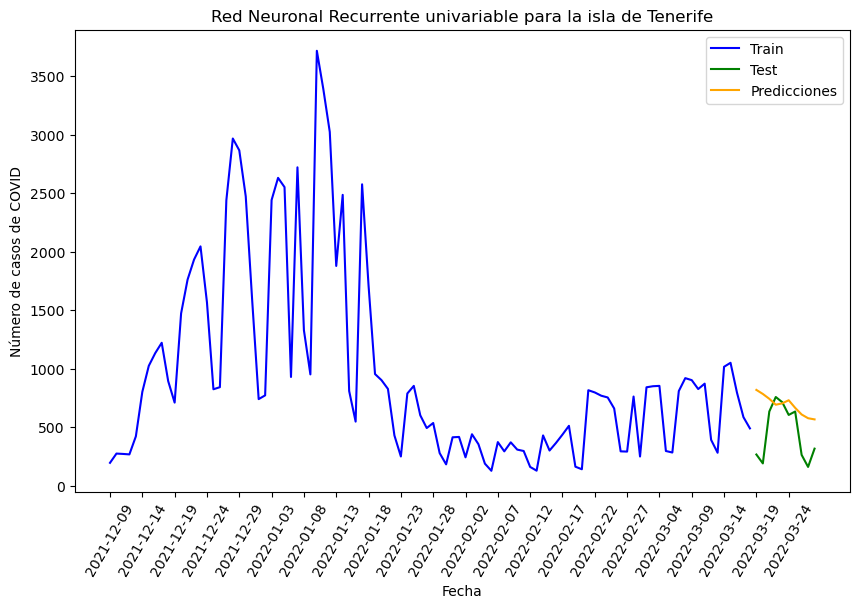

In [13]:
datos_train = datos_Tenerife_uni.iloc[:n_train]
visualizar_historico(datos_train,y_test,y_pred,'',100,fechas,tit)

In [14]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 104307.7153197065
Error absoluto medio (MAE) del modelo: 249.68641357421876
Raíz del error cuadrático medio (RMSE) del modelo: 322.9670498978286


# Red Neuronal Recurrente multivariable con variables de pandemia

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_covid_scaled = scaler.fit_transform(datos_Tenerife_mult_covid)


# Escalador para las predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_covid_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_covid[objetivo]).reshape(-1, 1))

In [16]:
n_train = len(datos_Tenerife_mult_covid_scaled) - dias_prediccion


train = datos_Tenerife_mult_covid_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_covid_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_covid_scaled), :]

In [17]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [18]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 3s 70ms/step - loss: 0.0428 - val_loss: 0.0244
Epoch 2/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0376 - val_loss: 0.0226
Epoch 3/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0342 - val_loss: 0.0220
Epoch 4/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0321 - val_loss: 0.0216
Epoch 5/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0298 - val_loss: 0.0196
Epoch 6/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0273 - val_loss: 0.0184
Epoch 7/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0256 - val_loss: 0.0180
Epoch 8/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0230 - val_loss: 0.0171
Epoch 9/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0226 - val_loss: 0.0166
Epoch 10/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0218 - val_loss: 0.0162
Epoch 11/50
7/7 [============

In [19]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 286ms/step


In [20]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 269, número de casos predichos 647.06915
2022-03-20: número de casos reales 193, número de casos predichos 608.72797
2022-03-21: número de casos reales 636, número de casos predichos 571.8663
2022-03-22: número de casos reales 760, número de casos predichos 530.98706
2022-03-23: número de casos reales 716, número de casos predichos 557.16394
2022-03-24: número de casos reales 607, número de casos predichos 600.5611
2022-03-25: número de casos reales 636, número de casos predichos 553.5791
2022-03-26: número de casos reales 266, número de casos predichos 503.70718
2022-03-27: número de casos reales 163, número de casos predichos 471.0476
2022-03-28: número de casos reales 319, número de casos predichos 460.6495


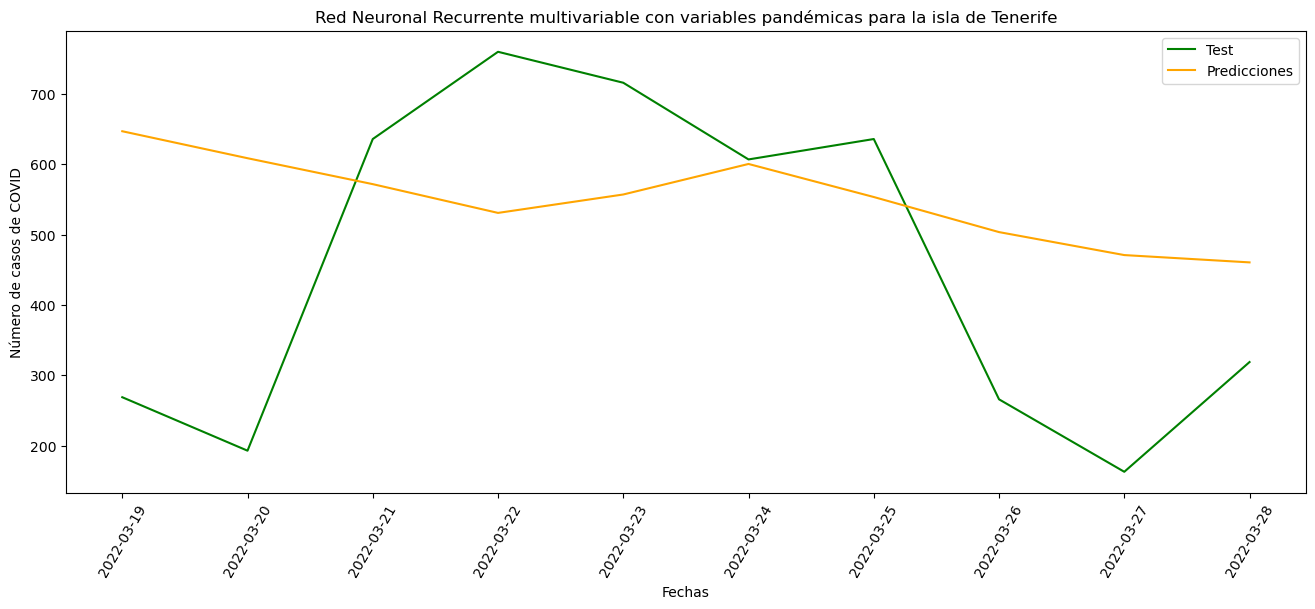

In [21]:
tit = 'Red Neuronal Recurrente multivariable con variables pandémicas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

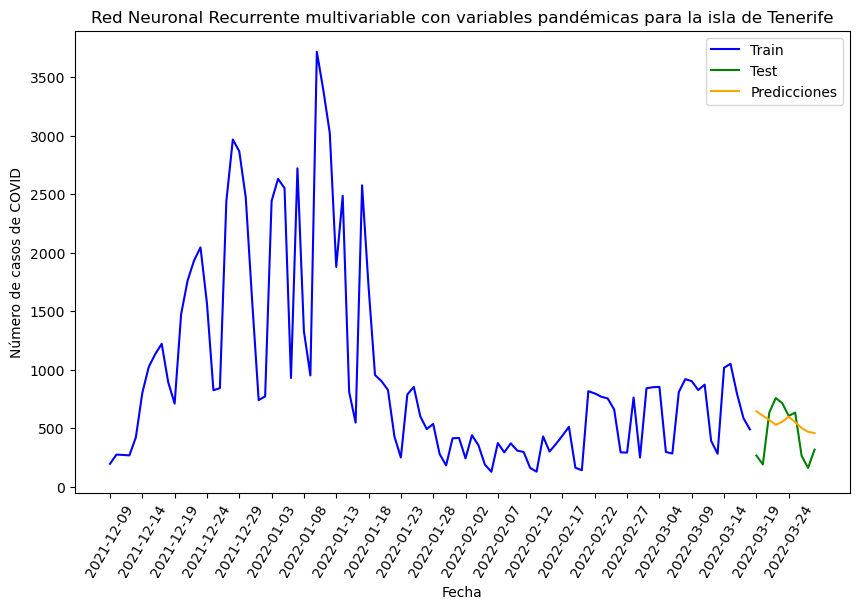

In [22]:
datos_train = datos_Tenerife_mult_covid.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [23]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 57585.22617307026
Error absoluto medio (MAE) del modelo: 202.20439453125
Raíz del error cuadrático medio (RMSE) del modelo: 239.96921922002883


# Red Neuronal Recurrente multivariable con variables atmosféricas

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_atm_scaled = scaler.fit_transform(datos_Tenerife_mult_atm)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_atm_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_atm[objetivo]).reshape(-1, 1))

In [25]:
n_train = len(datos_Tenerife_mult_atm_scaled) - dias_prediccion


train = datos_Tenerife_mult_atm_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_atm_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_atm_scaled), :]

In [26]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [27]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 3s 69ms/step - loss: 0.0445 - val_loss: 0.0257
Epoch 2/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0393 - val_loss: 0.0240
Epoch 3/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0372 - val_loss: 0.0217
Epoch 4/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0353 - val_loss: 0.0201
Epoch 5/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0325 - val_loss: 0.0195
Epoch 6/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0303 - val_loss: 0.0187
Epoch 7/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0283 - val_loss: 0.0196
Epoch 8/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0263 - val_loss: 0.0176
Epoch 9/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0243 - val_loss: 0.0184
Epoch 10/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0238 - val_loss: 0.0197
Epoch 11/50
7/7 [============

In [28]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 287ms/step


In [29]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 269, número de casos predichos 833.2387
2022-03-20: número de casos reales 193, número de casos predichos 794.0343
2022-03-21: número de casos reales 636, número de casos predichos 751.9865
2022-03-22: número de casos reales 760, número de casos predichos 710.78687
2022-03-23: número de casos reales 716, número de casos predichos 724.2121
2022-03-24: número de casos reales 607, número de casos predichos 746.9721
2022-03-25: número de casos reales 636, número de casos predichos 690.9822
2022-03-26: número de casos reales 266, número de casos predichos 633.77075
2022-03-27: número de casos reales 163, número de casos predichos 600.33777
2022-03-28: número de casos reales 319, número de casos predichos 583.70374


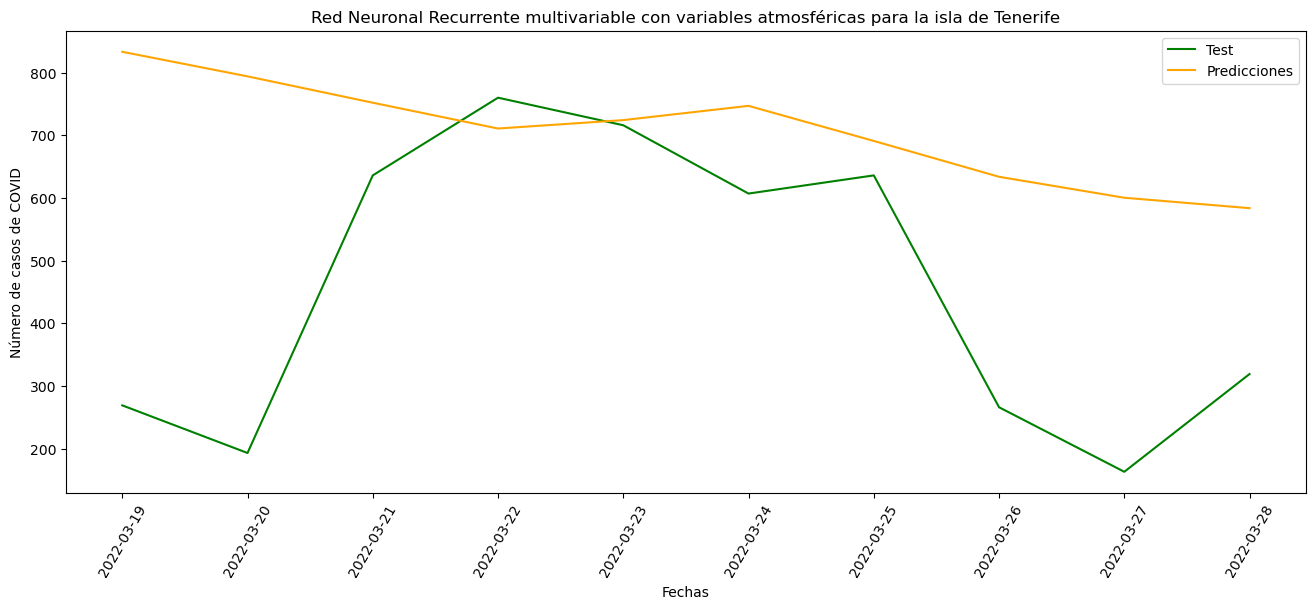

In [30]:
tit = 'Red Neuronal Recurrente multivariable con variables atmosféricas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

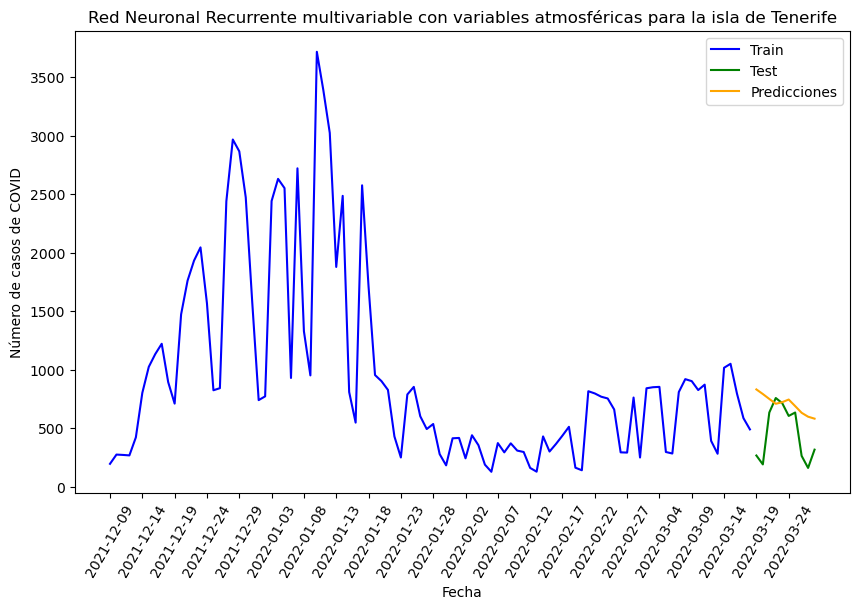

In [31]:
datos_train = datos_Tenerife_mult_atm.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [32]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 111475.27419090868
Error absoluto medio (MAE) del modelo: 260.3451293945312
Raíz del error cuadrático medio (RMSE) del modelo: 333.8791311102098


# Red Neuronal Recurrente multivariable con todas las variables

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_total_scaled = scaler.fit_transform(datos_Tenerife_mult_total)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_total_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_total[objetivo]).reshape(-1, 1))

In [34]:
n_train = len(datos_Tenerife_mult_total_scaled) - dias_prediccion


train = datos_Tenerife_mult_total_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_total_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_total_scaled), :]

In [35]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [36]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 3s 72ms/step - loss: 0.0377 - val_loss: 0.0197
Epoch 2/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0322 - val_loss: 0.0169
Epoch 3/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0283 - val_loss: 0.0155
Epoch 4/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0249 - val_loss: 0.0161
Epoch 5/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0231 - val_loss: 0.0148
Epoch 6/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0200 - val_loss: 0.0136
Epoch 7/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0198 - val_loss: 0.0138
Epoch 8/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0189 - val_loss: 0.0126
Epoch 9/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0185 - val_loss: 0.0170
Epoch 10/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0174 - val_loss: 0.0120
Epoch 11/50
7/7 [============

In [37]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 295ms/step


In [38]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 269, número de casos predichos 721.1726
2022-03-20: número de casos reales 193, número de casos predichos 682.34406
2022-03-21: número de casos reales 636, número de casos predichos 649.8634
2022-03-22: número de casos reales 760, número de casos predichos 602.8916
2022-03-23: número de casos reales 716, número de casos predichos 641.1086
2022-03-24: número de casos reales 607, número de casos predichos 687.52856
2022-03-25: número de casos reales 636, número de casos predichos 623.66846
2022-03-26: número de casos reales 266, número de casos predichos 550.5305
2022-03-27: número de casos reales 163, número de casos predichos 504.5523
2022-03-28: número de casos reales 319, número de casos predichos 490.03162


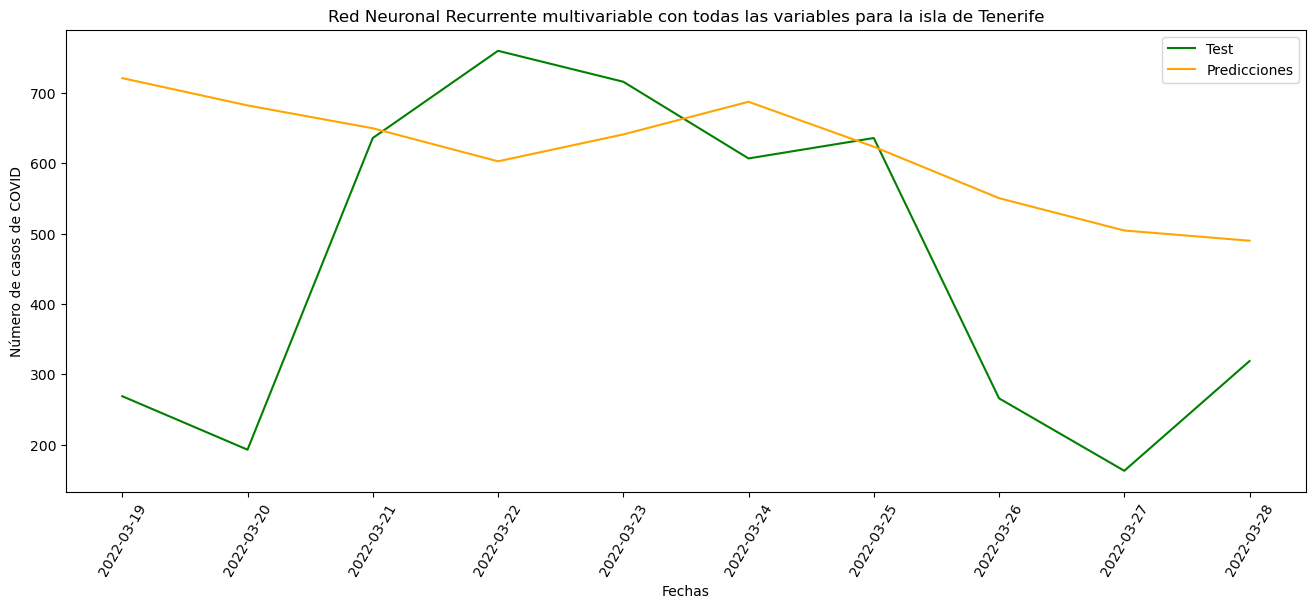

In [39]:
tit = 'Red Neuronal Recurrente multivariable con todas las variables para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

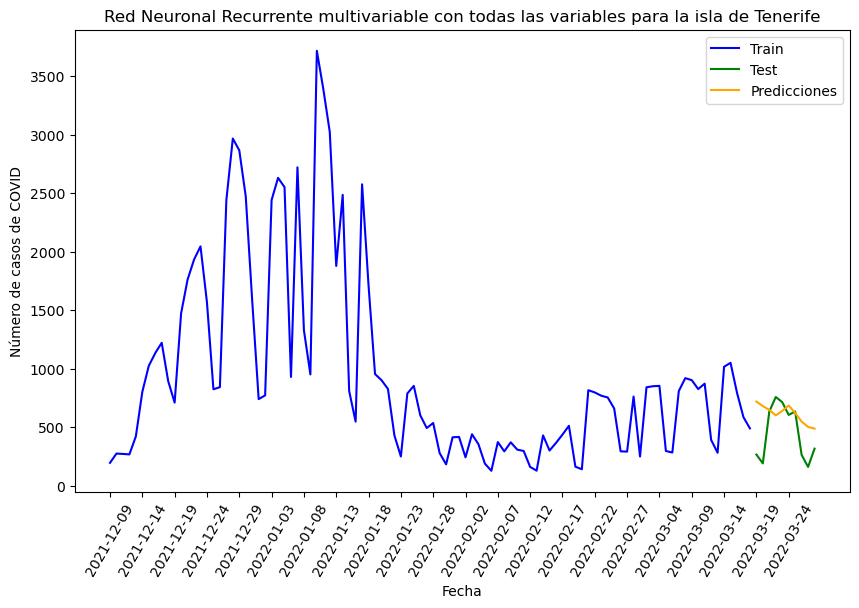

In [40]:
datos_train = datos_Tenerife_mult_total.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [41]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 70790.59629352503
Error absoluto medio (MAE) del modelo: 207.73544311523438
Raíz del error cuadrático medio (RMSE) del modelo: 266.0650226796544
